# Appendix 4 - System latencies

Brain computer interface (BCI) systems must process neural signals with consistent timing in order to support adequate system performance. Thus, it is important to have the capability to determine whether a particular BCI configuration (hardware or software) provides adequate timing performance for a particular experiment. This appendix describes the latencies present when using _OpenBCI-Stream_ for acquisition and distributed EEG signal processing <cite data-footcite="wilson2010procedure">wilson2010procedure</cite>.

In [1]:
from kafka import KafkaConsumer, KafkaProducer
import pickle
from datetime import datetime
import ntplib
import numpy as np
from matplotlib import pyplot as plt
import markdown_table

from IPython.display import display, Markdown, Latex

show = lambda table:display(Markdown(str(table)))

HOST = '192.168.1.1'

def show_latencies(latencies, offset=0, title=''):
    
    plt.figure(figsize=(10, 5), dpi=90)
    S = len(latencies['Block duration']) + 1
        
    p = 0
    for c, latency in enumerate(latencies):
        if latency.startswith('_'):
            p += 1
            continue
        
        plt.plot(np.array(latencies[latency]) + offset, label=latency, color=f'C{c-p}')
        
        if latency == 'Block duration':
            plt.hlines(np.mean(latencies[latency]), 0, S, color=f'C{c-p}', alpha=0.5, linestyle='--', linewidth=3)
            plt.fill_between(range(S), np.mean(latencies[latency])-np.std(latencies[latency]), np.mean(latencies[latency])+np.std(latencies[latency]), color=f'C{c-p}', alpha=0.07)
        else:
            plt.hlines(np.min(np.array(latencies[latency]) + offset), 0, S, color=f'C{c-p}', alpha=0.5, linestyle='--', linewidth=3)
            plt.fill_between(range(S), np.min(np.array(latencies[latency]) + offset)-np.std(np.array(latencies[latency]) + offset), np.min(np.array(latencies[latency]) + offset)+np.std(np.array(latencies[latency]) + offset), color=f'C{c-p}', alpha=0.07)

    plt.xlim(0, S)
    plt.ylim(-np.mean(latencies['Block duration'])*0.1)
    plt.legend(loc=4)
    plt.grid(True)
    plt.xlabel('Samples')
    plt.ylabel('Latency')
    plt.title(f'Latencies {title}')
    plt.show()

<center>
<img src='images/latencies.png'></img>
</center>

## Latency Definitions

### Real-time
The term **real-time** is used somewhat loosely, indicating only that the BCI system is able to process an entire block of data and update the output device before the next sample block is ready for processing. However, the degree to which the BCI system can be considered real-time is dependent on many factors, including the operating system, computer hardware specifications, and output device hardware. Furthermore, even if the mean overall processing and output time is less than the sample block size, large variability in this timing can significantly affect BCI performance, and must therefore be accounted for <cite data-footcite="wilson2010procedure">wilson2010procedure</cite>.

### Sample block size and Block duration ($T_2$ - $T_{-1}$)
Ideally, the block duration should be identical to the sample block size; however, inconsistencies in operating system timing may interrupt and delay data acquisition, causing the time period between data blocks to be different than the actual block size, introducing a timing jitter.

The block duration is the primary indicator of the system’s ability to perform online signal processing in a BCI experiment. It is important to realize that the block duration is measured from the perspective of the software, and is not the same as the block size. That is, the block duration will never typically be less than the block size (i.e., the length of a block of data acquired from the ADC), but it can be longer than the block size if the system latency is longer than the block size.

### ADC buffer ($T_{-1}$ - $T_{-2}$)
The ADC (analog to digital converter) buffer needs to be filled with an amount of raw data before digitize, this factor can be configured from <a href='https://docs.openbci.com/docs/05ThirdParty/03-WiFiShield/WiFiAPI#send-latency-http-requests-for-tuning'>WiFi Shield properties</a>. Over Serial protocol, this latency can be related to RFduino protocol transmission.

### Acquisition ($T_0$ - $T_{-1}$)
This is the delay between the time that the final sample in a sample block is digitized to when the sample block has been acquired by the software and is available to the software for processing. Depending on configuration, this latency may comprise physical signal delay in the amplifier, digitization, transmission from the ADC to the PC, and processing time inside a hardware driver.

## Methods for measuring latencies

All measures performed will use timestamps and software methods, this is possible due to the Kakfa protocol that registers production timestamps and other ones that are packed with the data stream. For this specific debugging, the acquisition runs on a **Raspberry Pi 4** and the data stream is **collected remotely**.


This measures can be done with this simple script that use an existing data stream:

In [72]:
def get_latencies(samples=60):
    openbci_consumer = KafkaConsumer(bootstrap_servers=[f'{HOST}:9092'],
                                         value_deserializer=pickle.loads,
                                         auto_offset_reset='latest')
    openbci_consumer.subscribe(['eeg'])
    
    latencies = {}
    for record in openbci_consumer:

        reference = datetime.fromtimestamp(record.timestamp / 1000)
        timestamp_binary = datetime.fromtimestamp(record.value['context']['timestamp.binary'])
        timestamp_binary_consume = datetime.fromtimestamp(record.value['context']['timestamp.binary.consume'])
        timestamp_eeg = datetime.fromtimestamp(record.value['context']['timestamp.eeg'])

        latencies.setdefault('Block duration', []).append(reference.timestamp())    
        latencies.setdefault('Binary produced', []).append((reference - timestamp_binary).total_seconds() * 1000)
        latencies.setdefault('Binary consumed', []).append((reference - timestamp_binary_consume).total_seconds() * 1000)
        latencies.setdefault('EEG produced', []).append((reference - timestamp_eeg).total_seconds() * 1000)
        latencies.setdefault('_EEG consumed', []).append((datetime.now() - reference).total_seconds()*1000)

        if len(latencies['Block duration']) >= samples:
            print('done')
            break
    latencies['Block duration'] = np.diff(latencies['Block duration'])*1000
    
    return latencies

For a configuration of 100 ms blocks, 8 channels and 1000 samples per second:

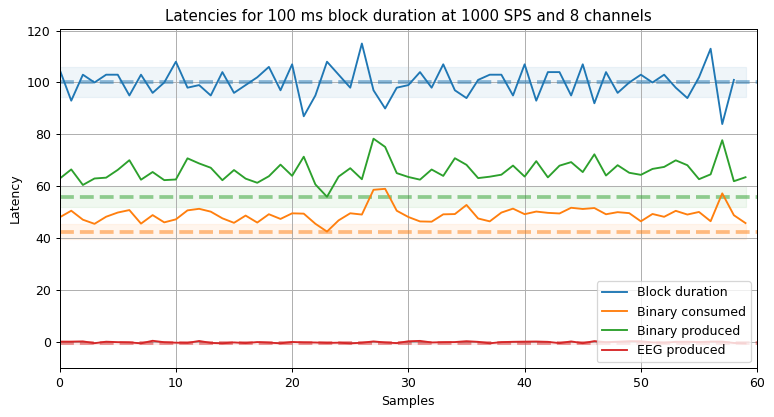

In [219]:
latencies_100 = get_latencies(samples=60)
show_latencies(latencies_100, title='for 100 ms block duration at 1000 SPS and 8 channels')

This plot shows the cumulative latency from the first process (acquisition) to deserialization of the EEG.

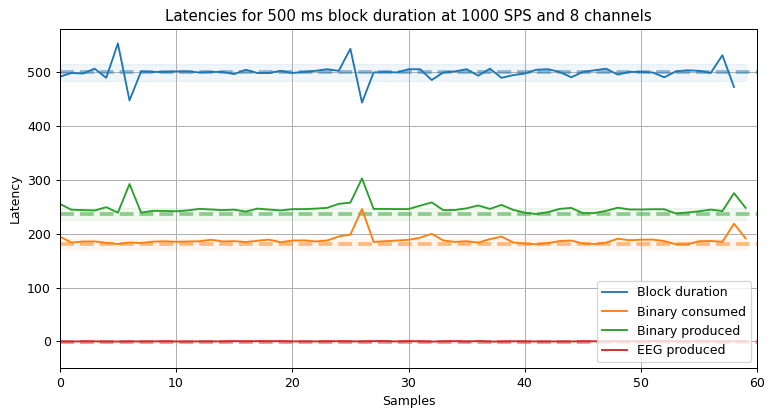

In [220]:
latencies_500 = get_latencies(samples=60)
show_latencies(latencies_500, title='for 500 ms block duration at 1000 SPS and 8 channels')

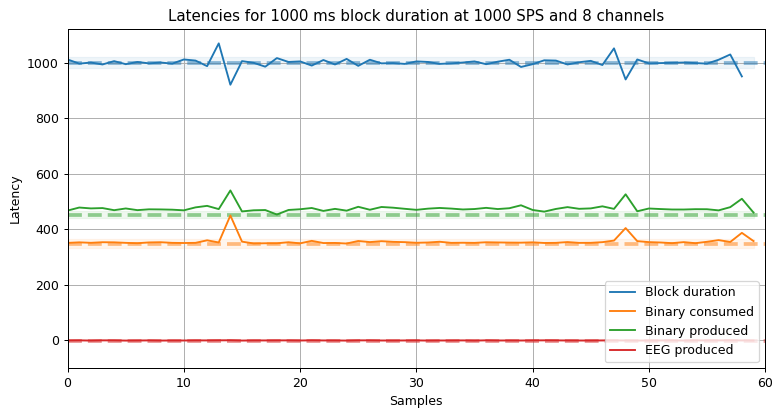

In [221]:
latencies_1000 = get_latencies(samples=60)
show_latencies(latencies_1000, title='for 1000 ms block duration at 1000 SPS and 8 channels')

## Additional latency for distributed systems

Since the data transmission is not instantaneous, access to the stream remotely adds a latency that can measure mainly in two features.

### NTP offset

Before measuring the latency in two different systems is needed to get the systems synchronized, the implementation used for this test is synchronized with the Network Time Protocol server running on Raspberry Pi.

In [157]:
client = ntplib.NTPClient()
ntp_offset = client.request(HOST).offset * 1000
print(f" NTP offset: {ntp_offset :.2f} ms")

 NTP offset: 4.21 ms


### Distributed latency

This latency is related with Kafka, is the time from the EEG producer (on Raspberry) to EEG consumed in the remote system.

In [158]:
print(f"Distributed: {np.min(latencies_100['_EEG consumed'])} ms")

Distributed: 2.444 ms


The final `offset` is:

In [227]:
offset = np.min(latencies_100['_EEG consumed']) + ntp_offset
print(f"Total offset: {offset:.2f} ms")

Total offset: 6.66 ms


This `offset` affects all latencies except the block duration.

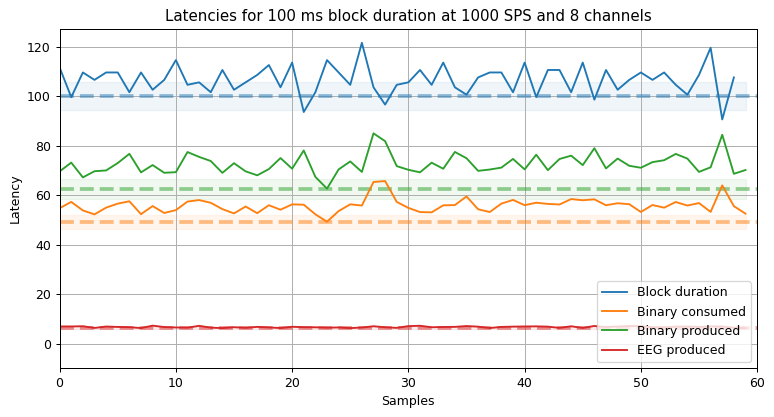

In [222]:
show_latencies(latencies_100, offset=offset, title='for 100 ms block duration at 1000 SPS and 8 channels')

## Results

Has been proved that OpenBCI-Stream can distribute EEG signal (with metadata) in approximately the 50% of the block duration, this performance allows the user through asynchronous data processing the development of real-time multipurpose BCI systems.

Real-time issues are paradigm-agnostic since some implementations require windows of 2.5 seconds <cite data-footcite="mora2020brain">mora2020brain</cite> or more, even short time control signals like P300 need commonly too many trials <cite data-footcite="nicolas-alonso_brain_2012">nicolas-alonso_brain_2012</cite>, which in practice is an even bigger window.

Block duration|measured block duration|measured block duration jitter|Latency system|Latency system jitter
-|-|-|-|-
50 ms |50.37 ms |13.23 ms |35.03 ms |11.74 ms
100 ms |100.07 ms |5.72 ms |56.00 ms |4.01 ms
300 ms |300.25 ms |101.64 ms |134.82 ms |9.71 ms
500 ms |500.15 ms |15.20 ms |236.72 ms |11.11 ms
800 ms |800.08 ms |23.01 ms |380.45 ms |15.27 ms
1000 ms |1000.36 ms |20.04 ms |453.53 ms |13.03 ms

<img src='images/block_vs_latency.png'></img>

In [6]:
columns = [f'{l} ms' for l in [50, 100, 300, 500, 800, 1000]]

matrix = []
# for key in ['Block duration', 'Binary produced']:
    
for i, lat in enumerate([latencies_50, latencies_100, latencies_300, latencies_500, latencies_800, latencies_1000]):
    
    row = [columns[i]]    
    for key in ['Block duration', 'Binary produced']:
        
        if key in ['Block duration', 'EEG produced']:
            row.extend([f"{np.mean(lat[key]):.2f} ms", f"{np.std(lat[key]):.2f} ms"])
        else:
            row.extend([f"{np.min(lat[key]):.2f} ms", f"{np.std(lat[key]):.2f} ms"])
        
    matrix.append(row)
    
# matrix[1][0] = 'Total latency'
table = markdown_table.Table(['Block size', 'Block duration', 'Block duration jitter', 'Latency system', 'Latency system jitter'], np.array(matrix))
show(table)
print(str(table))

Block size|Block duration|Block duration jitter|Latency system|Latency system jitter
-|-|-|-|-
50 ms |50.37 ms |13.23 ms |35.03 ms |11.74 ms
100 ms |100.07 ms |5.72 ms |56.00 ms |4.01 ms
300 ms |300.25 ms |101.64 ms |134.82 ms |9.71 ms
500 ms |500.15 ms |15.20 ms |236.72 ms |11.11 ms
800 ms |800.08 ms |23.01 ms |380.45 ms |15.27 ms
1000 ms |1000.36 ms |20.04 ms |453.53 ms |13.03 ms

Block size|Block duration|Block duration jitter|Latency system|Latency system jitter
-|-|-|-|-
50 ms |50.37 ms |13.23 ms |35.03 ms |11.74 ms
100 ms |100.07 ms |5.72 ms |56.00 ms |4.01 ms
300 ms |300.25 ms |101.64 ms |134.82 ms |9.71 ms
500 ms |500.15 ms |15.20 ms |236.72 ms |11.11 ms
800 ms |800.08 ms |23.01 ms |380.45 ms |15.27 ms
1000 ms |1000.36 ms |20.04 ms |453.53 ms |13.03 ms


In [9]:
pip install markdown_table

Using legacy 'setup.py install' for markdown-table, since package 'wheel' is not installed.
    Running setup.py install for markdown-table ... done
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pickle
from matplotlib import pyplot as plt
import numpy as np

latencies_100 = pickle.load(open('latency_100.pk', 'rb'))
latencies_50 = pickle.load(open('latency_50.pk', 'rb'))
latencies_500 = pickle.load(open('latency_500.pk', 'rb'))
latencies_800 = pickle.load(open('latency_800.pk', 'rb'))
latencies_300 = pickle.load(open('latency_300.pk', 'rb'))
latencies_1000 = pickle.load(open('latency_1000.pk', 'rb'))

for lat in [latencies_100, latencies_500, latencies_1000]:
    
    lat['Binary produced'] = lat['Binary prodused'][:]
    del lat['Binary prodused']

    lat['EEG produced'] = lat['EEG prodused'][:]
    del lat['EEG prodused']

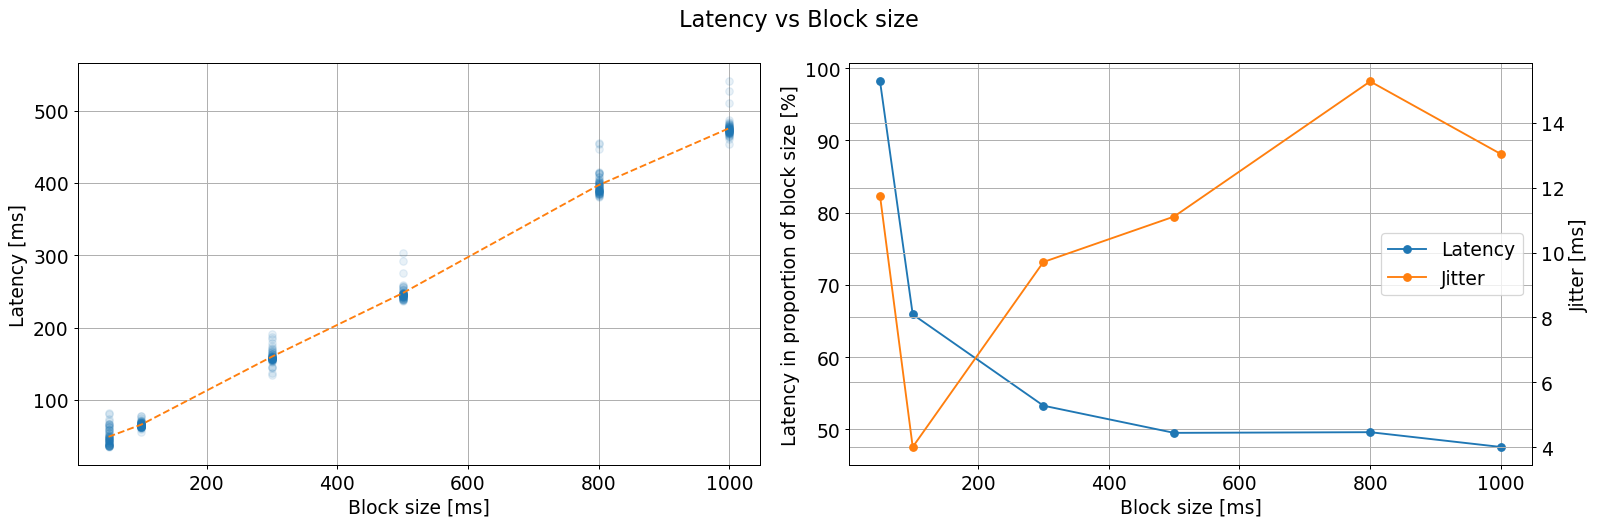

In [42]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

import matplotlib
matplotlib.rc('font', **font)

pairs = list([
    [50, latencies_50['Binary produced']],
    [100, latencies_100['Binary produced']], 
    [300, latencies_300['Binary produced']], 
    [500, latencies_500['Binary produced']], 
    [800, latencies_800['Binary produced']], 
    [1000, latencies_1000['Binary produced']],
   ])

plt.figure(figsize=(18, 6), dpi=90)

plt.suptitle("Latency vs Block size")

plt.subplot(121)
for v,l in pairs:
    plt.plot([v]*len(l), l, 'o', alpha=0.1, color='C0')
plt.plot(*zip(*[[v, np.mean(l)] for v, l in pairs]), color='C1', linestyle='--')
plt.xlabel('Block size [ms]')
plt.ylabel('Latency [ms]')
plt.grid(True)

#plt.subplot(122)

ax1 = plt.subplot(122)

lns1 = ax1.plot(*zip(*[[v, 100*(np.mean(l)/v)] for v, l in pairs]), color='C0', linestyle='-', marker='o', label='Latency')
ax1.set_xlabel('Block size [ms]')
ax1.set_ylabel('Latency in proportion of block size [%]')
plt.grid(True)
#plt.legend(loc='upper left')

ax2 = ax1.twinx() 
ax2.set_ylabel('Jitter [ms]')  # we already handled the x-label with ax1
lns2 = ax2.plot(*zip(*[[v, np.std(l)] for v, l in pairs]), color='C1', linestyle='-', marker='o', label='Jitter')
ax2.tick_params(axis='y')
#plt.legend(loc='upper right')

plt.grid(True)

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='right')

plt.tight_layout()
plt.savefig('images/block_vs_latency.png')

---
.. footbibliography::